In [1]:
import tensorflow as tf

In [2]:
from keras.layers import Conv1D, Dense, Dropout, Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from keras.utils import plot_model

In [5]:
from keras.models import Model

In [6]:
import numpy as np

In [7]:
import pandas as pd

In [8]:
amazon_review = pd.read_csv('1429_1.csv')

/Users/mayoor/dev/kaggle/tc2/tc2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
ratings_df = amazon_review[['reviews.text','reviews.rating']]

In [10]:
ratings_df.dropna(inplace=True)

/Users/mayoor/dev/kaggle/tc2/tc2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
ratings_df['reviews.rating'].value_counts()

5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: reviews.rating, dtype: int64

In [12]:
maxlen = 1024
alphabet_list = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\|_@#$%ˆ&* ̃‘+-=<>()[]{} "
alphabet_index = {v:i for i,v in enumerate(alphabet_list)}
matrix = np.eye(len(alphabet_list))

In [13]:
def prepare_data_for_character_cnn(documents, maxlen,alphabet_list, alphabet_index, matrix):
    doc_array = []
    for doc in documents:
        doc_char_list = []
        if len(str(doc)) <= maxlen:
            try:
                doc = str(doc) + "".join(['`']*(maxlen-len(doc)+1))
            except:
                print (type(doc),doc)
        for c in str(doc).lower()[:maxlen]:
            doc_char_list.append(matrix[alphabet_index[c]].T if c in alphabet_index else np.zeros(len(alphabet_list)))
        doc_array.append(np.array(doc_char_list).T)
    return np.array(doc_array)

In [14]:
train, test = train_test_split(ratings_df,test_size=0.2, random_state=42,stratify=ratings_df['reviews.rating'])

In [15]:
charcnn_dataset_train = prepare_data_for_character_cnn(train['reviews.text'].values.tolist(), maxlen, alphabet_list, alphabet_index, matrix)
charcnn_dataset_test = prepare_data_for_character_cnn(test['reviews.text'].values.tolist(), maxlen, alphabet_list, alphabet_index, matrix)

In [16]:
print(charcnn_dataset_train[0].shape)
print(charcnn_dataset_test[0].shape)

(71, 1024)
(71, 1024)


In [17]:
def get_char_cnn_model(kernels, maxlen, char_len):
    input = Input(shape=(char_len,maxlen))
    cnns = []
    cnn = input
    for kernel in kernels:
        cnn = Conv1D(kernel_size=kernel, filters=128, padding="SAME")(cnn)
        cnn = MaxPooling1D(2)(cnn)
#         cnn_average = GlobalAveragePooling1D()(cnn)
#         cnns.append(cnn_max)
#         cnns.append(cnn_average)
#     cnn_layer = Concatenate()(cnns)
    cnn_flatten = Flatten()(cnn)
    output = Dense(128, activation='relu')(cnn_flatten)
    output = Dropout(0.2)(output)
    output = Dense(64, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(32, activation='relu')(output)
    output = Dropout(0.2)(output)
    output = Dense(5, activation='softmax')(output)
    model = Model(input, output)
    return model
    

In [18]:
char_cnn_model = get_char_cnn_model([7,6,5,4,3,2],maxlen, len(alphabet_list))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
char_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 71, 1024)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 128)           917632    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 35, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 128)           98432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 128)           82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 128)            0         
__________

In [20]:
plot_model(char_cnn_model, 'char_cnn.png')

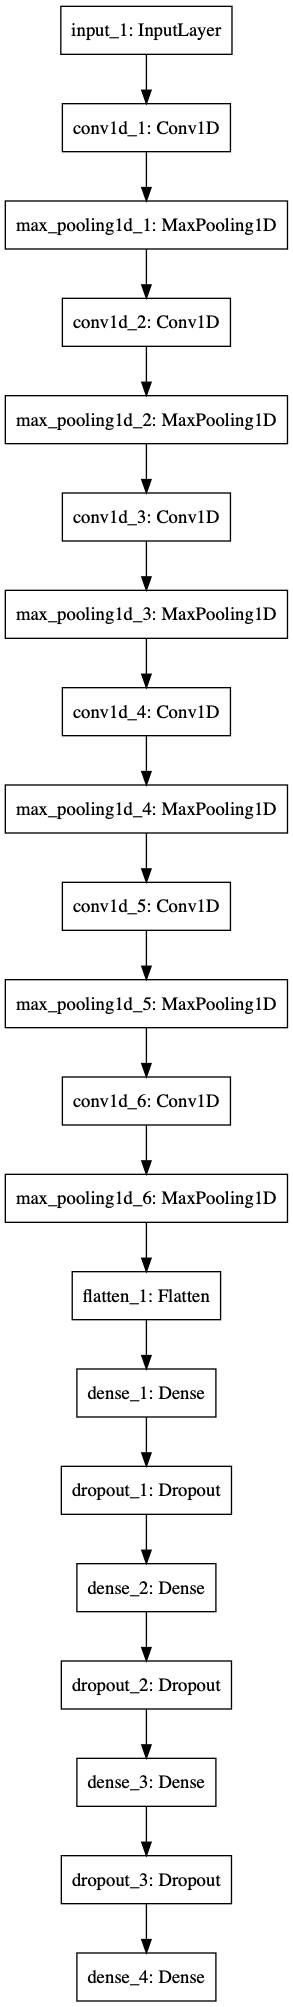

In [21]:
from IPython import display
display.Image('char_cnn.png')

In [22]:
char_cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

In [23]:
train_y = train['reviews.rating'].values-1
test_y = test['reviews.rating'].values-1

In [24]:
char_cnn_model.fit(charcnn_dataset_train,train_y.tolist(),validation_data=(charcnn_dataset_test,test_y.tolist()),batch_size=128, epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 27700 samples, validate on 6926 samples
Epoch 1/10
27700/27700 [==============================] - 123s 4ms/step - loss: 0.9031 - acc: 0.6781 - val_loss: 0.8325 - val_acc: 0.6865
Epoch 2/10
27700/27700 [==============================] - 130s 5ms/step - loss: 0.8324 - acc: 0.6869 - val_loss: 0.8282 - val_acc: 0.6865
Epoch 3/10
27700/27700 [==============================] - 130s 5ms/step - loss: 0.7495 - acc: 0.6932 - val_loss: 0.8680 - val_acc: 0.6711
Epoch 4/10
27700/27700 [==============================] - 128s 5ms/step - loss: 0.6499 - acc: 0.7260 - val_loss: 0.9763 - val_acc: 0.6656
Epoch 5/10
27700/27700 [==============================] - 130s 5ms/step - loss: 0.5460 - acc: 0.7755 - val_loss: 1.2320 - val_acc: 0.6393
Epoch 6/10
27700/27700 [==============================] - 133s 5ms/step - loss: 0.4382 - acc: 0.8244 - val_loss: 1.2721 - val_acc: 0.5746
Epoch 7/10
27700/27700 [==============================] - 128s 5ms/step - l

In [25]:
# for item in charcnn_dataset:
#     if item.shape[0] != 71 or item.shape[1] != 1024:
#         print ("PROBLEM!!!!!",item.shape, item)

In [26]:
from sklearn.metrics import classification_report

In [27]:
values = char_cnn_model.predict(charcnn_dataset_test)

In [34]:
prediction = np.argmax(values,axis=1)

In [36]:
print(classification_report(test_y,prediction))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        82
         1.0       0.00      0.00      0.00        81
         2.0       0.07      0.02      0.04       300
         3.0       0.27      0.33      0.30      1708
         4.0       0.72      0.72      0.72      4755

   micro avg       0.58      0.58      0.58      6926
   macro avg       0.21      0.21      0.21      6926
weighted avg       0.56      0.58      0.57      6926



In [40]:
test_1 = prepare_data_for_character_cnn(['I hate this. worst ever.'], maxlen, alphabet_list, alphabet_index, matrix)


In [41]:
char_cnn_model.predict(test_1)

array([[1.03607366e-04, 1.19001408e-04, 2.64787138e-03, 3.11964661e-01,
        6.85164869e-01]], dtype=float32)